In [1]:
import ROOT as rt
import array as array
import os
import glob
from random import gauss
import numpy as np
import root_numpy as rtnpy
import pandas as pd
import h5py
from awkward import JaggedArray, Table
import matplotlib.pyplot as plt
import seaborn as sns

Welcome to JupyROOT 6.14/09


In [2]:
lumi=5750+2573+4242+4025+3104+7576+8632
print lumi
CrossSection=np.array([1973000000,117200,7760,642.1,185.9,32.05,9.365,0.8398,0.1124,0.006752,0.0001626])
EventNumber=np.array([3520.33,6875125,4150588,9344512.12,6571952,8456672.59,6680029,831433,692968,834414,11166471])
Scale=lumi*CrossSection/EventNumber
print Scale
MC_Compo=np.array(['QCD Flat','QCD Pt170to300','QCD Pt300to470','QCD Pt470to600','QCD Pt600to800','QCD Pt800to1000','QCD Pt1000to1400','QCD Pt1400to1800','QCD Pt1800to2400','QCD Pt2400to3200','QCD Pt3200toInf'])

35902
[2.01215926e+10 6.12020058e+02 6.71229040e+01 2.46697462e+00
 1.01555547e+00 1.36065230e-01 5.03324507e-02 3.62632943e-02
 5.82333499e-03 2.90515624e-04 5.22785149e-07]


In [3]:
fData=[]
path='/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_JetHTRun2016*.root'
files=glob.glob(path)
for f in files:
    fData.append(f)
print len(fData)
fMC=[
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt-15to7000_TuneCUETP8M1_FlatP6_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_170to300_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_300to470_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_470to600_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_600to800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_800to1000_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1000to1400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1400to1800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1800to2400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_2400to3200_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_3200toInf_TuneCUETP8M1_13TeV_pythia8.root'
    ]

print len(fMC)

7
11


# Functions to refill histograms to new bins

In [4]:
def Fill1D(h0,h,bins):
    N=h0.GetNbinsX()
    content=np.zeros((len(bins)-1),dtype=float)
    for i in range(len(bins)-1):
        content[i]=0
    for i in range(N):
        center=h0.GetBinCenter(i+1)
        index=np.digitize(np.array([center]),bins)
        if index[0] < len(bins):
            content[index[0]-1]+=h0.GetBinContent(i+1)
    for i in range(len(bins)-1):
        h.SetBinContent(i+1,content[i])

def Fill2D(h0,h,binx,biny):
    Nx=h0.GetNbinsX()
    Ny=h0.GetNbinsY()
    hx=h0.ProjectionX()
    hy=h0.ProjectionY()
    content=np.zeros((len(binx)-1,len(biny)-1),dtype=float)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            content[i][j]=0
    for i in range(Nx):
        for j in range(Ny):
            centerx=hx.GetBinCenter(i+1)
            indexx=np.digitize(np.array([centerx]),binx)
            centery=hy.GetBinCenter(j+1)
            indexy=np.digitize(np.array([centery]),biny)
            if indexx[0] < len(binx) and indexy[0] < len(biny):
                content[indexx[0]-1][indexy[0]-1]+=h0.GetBinContent(i+1,j+1)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            h.SetBinContent(i+1,j+1,content[i][j])

# Purity and stability calculation

In [5]:
def PurityStability(h0,bins):
    
    h=rt.TH2D("",";;",bins.shape[0]-1,(bins),bins.shape[0]-1,(bins))
    Fill2D(h0,h,bins,bins)
    hx=h.ProjectionX()
    hy=h.ProjectionY()
    N=hx.GetNbinsX()
    
    nreco_pergenbin=[]
    nreco_genanywhere=[]
    ngen_recoanywhere=[]
    for i in range(N):
        nreco_pergenbin.append(h.GetBinContent(i+1,i+1))
        nreco_genanywhere.append(hy.GetBinContent(i+1))
        ngen_recoanywhere.append(hx.GetBinContent(i+1))
    nreco_pergenbin=np.array(nreco_pergenbin)
    nreco_genanywhere=np.array(nreco_genanywhere)
    ngen_recoanywhere=np.array(ngen_recoanywhere)
    
    purity_arr=1.0*nreco_pergenbin/nreco_genanywhere
    stability_arr=1.0*nreco_pergenbin/ngen_recoanywhere
    
    purity=rt.TH1D("Purity",";;",bins.shape[0]-1,(bins))
    stability=rt.TH1D("Stability",";;",bins.shape[0]-1,(bins))
    
    for i in range(N):
        purity.SetBinContent(i+1,purity_arr[i])
        stability.SetBinContent(i+1,stability_arr[i])
    
    purity.SetLineWidth(2)
    purity.SetLineStyle(2)
    stability.SetLineWidth(2)
    stability.SetLineStyle(2)
    
    return purity,stability

# Do unfolding

In [6]:
def DoUnfolding(Response,Data_reco,MC_reco,MC_gen,HSname,MCname,gen_bins):
    
    tunfolderMC = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderMC.SetInput(MC_reco)
    MC_unfolded=tunfolderMC.DoUnfold(0.)
    MC_unfolded=tunfolderMC.GetOutput("MC_unfolded")
    
    tunfolderData = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderData.SetInput(Data_reco)
    Data_unfolded=tunfolderData.DoUnfold(0.)
    Data_unfolded=tunfolderData.GetOutput("Data_unfolded")
    
    MC_unfolded.SetMarkerStyle(2)
    MC_unfolded.SetMarkerColor(7)
    MC_unfolded.SetLineColor(7)
    MC_unfolded.SetLineWidth(1)
    
    Data_unfolded.SetMarkerStyle(22)
    Data_unfolded.SetMarkerColor(1)
    Data_unfolded.SetLineColor(1)
    Data_unfolded.SetLineWidth(2)
    
    MC_gen.SetMarkerStyle(5)
    MC_gen.SetMarkerColor(2)
    MC_gen.SetLineColor(2)
    
    ratio=rt.TH1D("Ratios "+HSname,"Ratios "+HSname+";"+HSname+";#frac{MC_unfolded}{MC_gen} ("+MCname+")",gen_bins.shape[0]-1,(gen_bins))
    ratio.Add(MC_unfolded)
    ratio.Divide(MC_gen)
    ratio.SetStats(0)
    ratio.SetMarkerStyle(5)
    ratio.SetMarkerColor(rt.kRed)
    ratio.SetLineColor(rt.kRed)
    ratio.GetYaxis().SetRangeUser(0.5,1.5)
    
    hs=rt.THStack(HSname,HSname)
    hs.Add(MC_unfolded,"E")
    hs.Add(MC_gen,"Hist")
    hs.Add(Data_unfolded,"E")
    
    leg=rt.TLegend(0.5, 0.5, 0.9, 0.8)
    #leg.SetTextSize(6)
    leg.AddEntry(Data_unfolded,"Data_unfolded",'p')
    leg.AddEntry(MC_unfolded,"MC_unfolded ("+MCname+")", 'p')
    leg.AddEntry(MC_gen,"MC_gen ("+MCname+")", 'f')
    leg.SetLineColor(0)
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    
    return hs,ratio,leg

# $\tau_3^{(0.5)}$

In [7]:
reco='recoJet_tau_0p5_3_WTA_kT_nom_dijetSel'
gen='genJet_tau_0p5_3_WTA_kT_dijetSel'
response='respJet_tau_0p5_3_WTA_kT_nom_dijetSel'

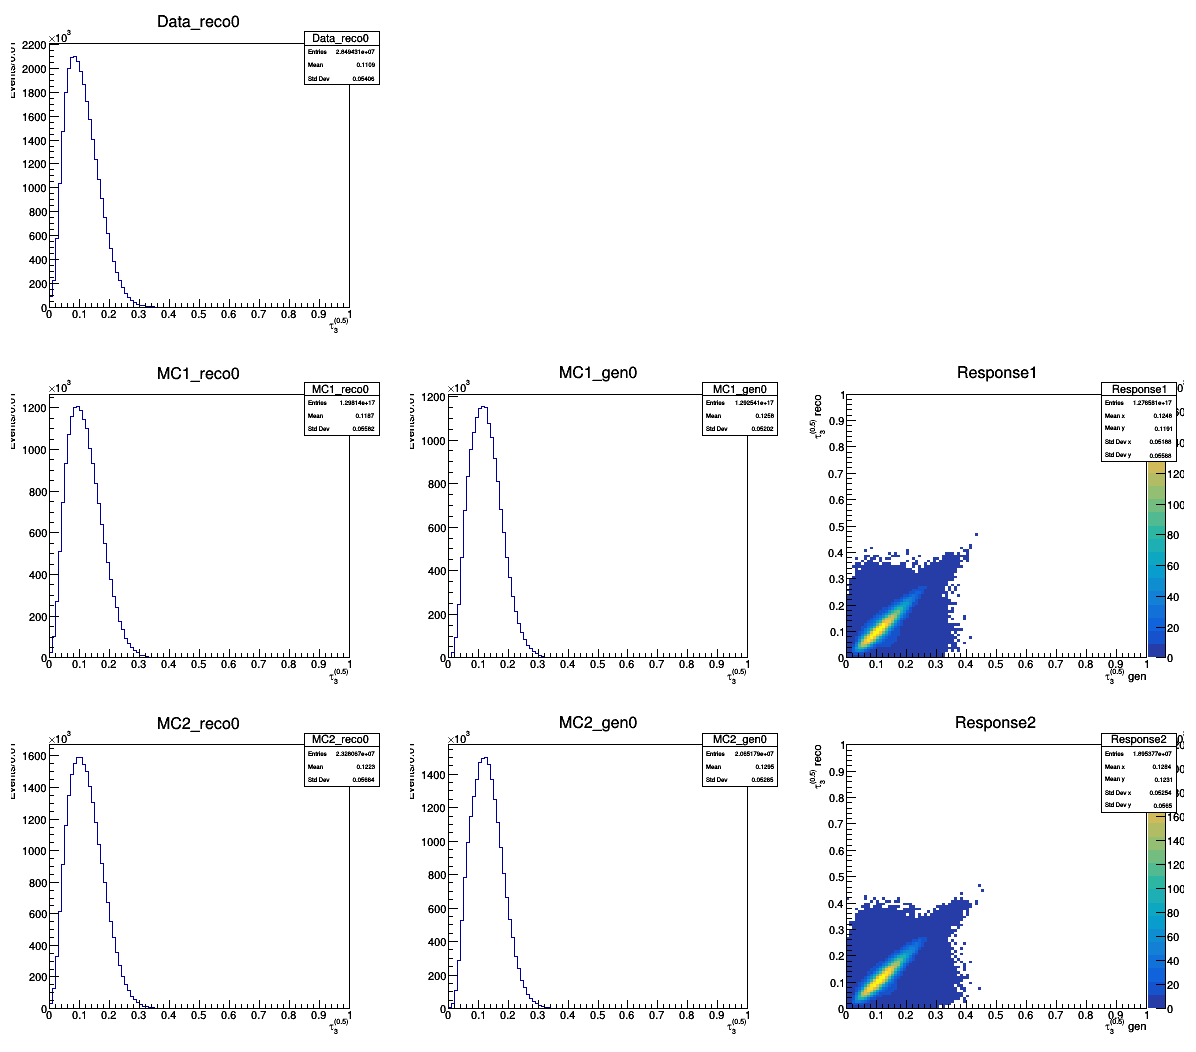

In [8]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{3}^{(0.5)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{3}^{(0.5)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{3}^{(0.5)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{3}^{(0.5)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{3}^{(0.5)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{3}^{(0.5)} gen;#tau_{3}^{(0.5)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{3}^{(0.5)} gen;#tau_{3}^{(0.5)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    MC2_reco0.Add(t.Get(reco),Scale[i])
    MC2_gen0.Add(t.Get(gen),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [9]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 5421.94836235 22223.7539267
0.015 28401.4930478 95183.5470528
0.025 102855.080676 259065.019011
0.035 275885.721853 482652.979171
0.045 501269.576439 720873.589356
0.055 745821.852712 915742.959304
0.065 945872.890251 1071691.22714
0.075 1088106.87332 1182778.0624
0.085 1193645.99946 1248772.93518
0.095 1280145.32683 1290483.3954
0.105 1364101.65297 1289247.50645
0.115 1380943.93404 1268259.63233
0.125 1371682.67924 1235537.00992
0.135 1335084.22003 1147314.978
0.145 1249969.71643 1075005.48067
0.155 1133197.24351 972871.901511
0.165 999483.996761 857263.531837
0.175 868041.513569 764440.878025
0.185 730708.520846 664503.914877
0.195 594312.612883 556209.658676
0.205 478120.369212 452502.272893
0.215 373523.646733 370676.885327
0.225 279819.172875 290884.287125
0.235 213768.278056 224448.596419
0.245 150697.088545 167674.83354
0.255 111363.023092 121307.982106
0.265 76617.4369985 91436.1298353
0.275 49995.7467641 63860.563632
0.285 38054.9809875 46423.7918568
0.295 26622.7169989 

# Different bins

In [10]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=4,start=0.,stop=0.3)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.47])))
reco_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.3)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.37,0.47])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.32)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.47])))
reco_bins1=np.array([x for x in np.linspace(num=9,start=0.,stop=0.32)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.39,0.47])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.36)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.47])))
reco_bins1=np.array([x for x in np.linspace(num=13,start=0.,stop=0.36)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.41,0.47])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=10,start=0.,stop=0.36)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.47])))
reco_bins1=np.array([x for x in np.linspace(num=19,start=0,stop=0.36)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.41,0.47])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=19,start=0.,stop=0.36)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.47])))
reco_bins1=np.array([x for x in np.linspace(num=37,start=0.,stop=0.36)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.41,0.47])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.1  0.2  0.3  0.47] 4
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.37 0.47] 8
[0.   0.08 0.16 0.24 0.32 0.47] 5
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.39 0.47] 10
[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.47] 7
[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.33 0.36 0.41
 0.47] 14
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.47] 10
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.41 0.47] 20
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.47] 19
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.41 0.47] 38


In [11]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{3}^{(0.5)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{3}^{(0.5)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{3}^{(0.5)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{3}^{(0.5)} gen;#tau_{3}^{(0.5)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{3}^{(0.5)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{3}^{(0.5)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{3}^{(0.5)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.1  0.2  0.3  0.47]
for binning 2
[0.   0.08 0.16 0.24 0.32 0.47]
for binning 3
[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.47]
for binning 4
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.47]
for binning 5
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.47]


Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 8 input bins and 4 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{3}^{(0.5)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #5 (xaxis:#tau_{3}^{(0.5)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 8 input bins and 4 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{3}^{(0.5)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #5 (xaxis:#tau_{3}^{(0.5)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Warning in <

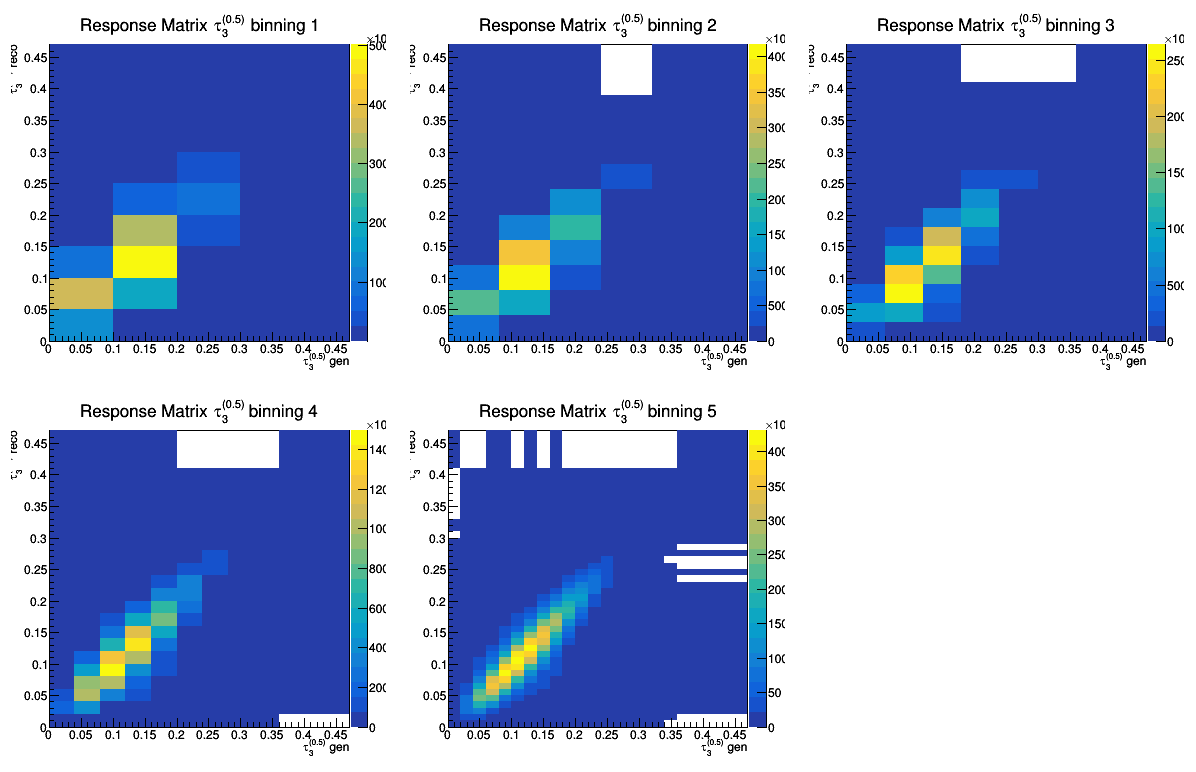

In [12]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


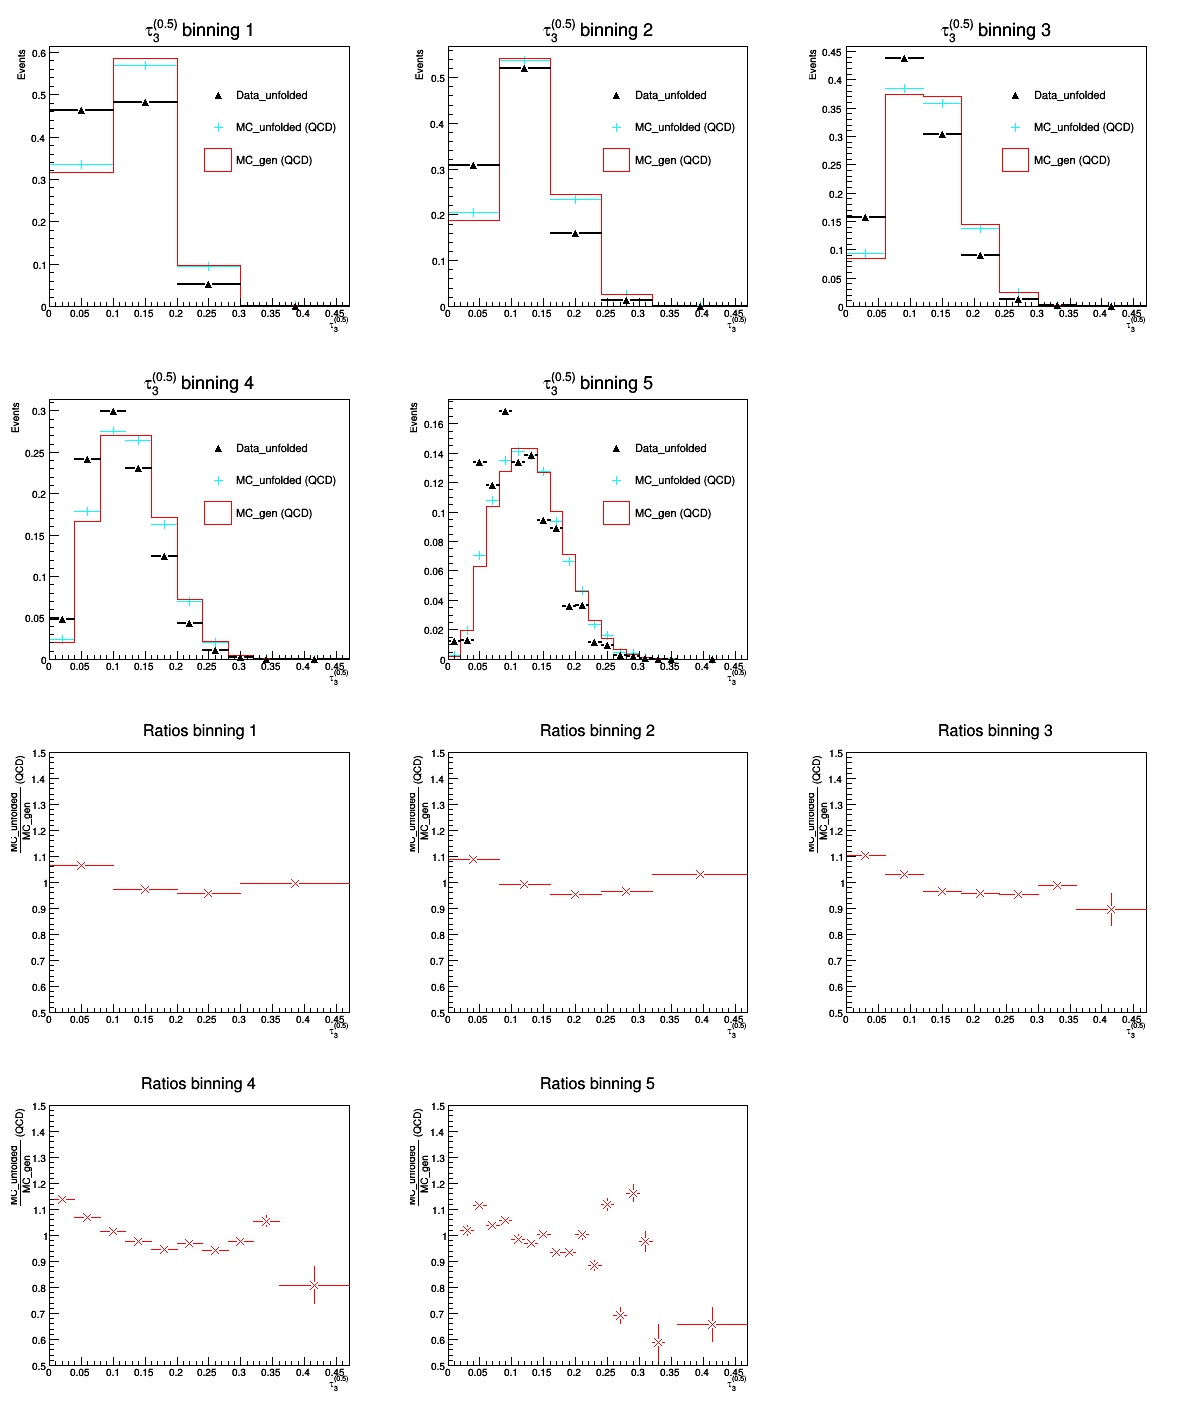

In [13]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{3}^{(0.5)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,6+len(gen_bins)):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

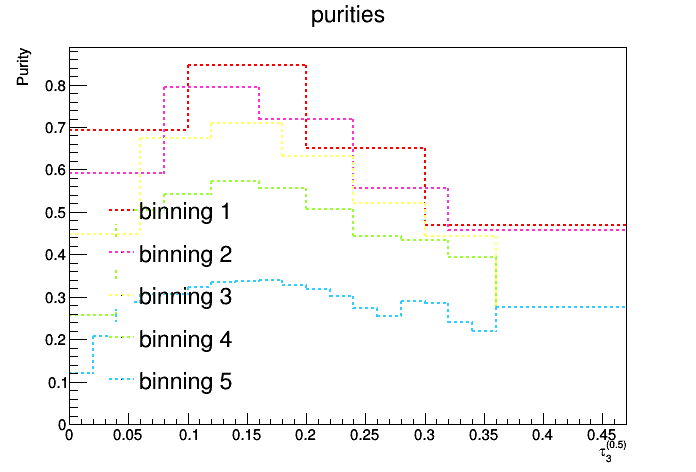

In [14]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{3}^{(0.5)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

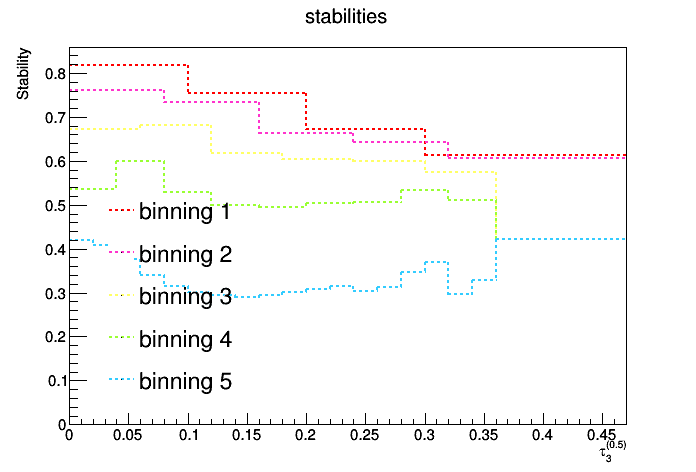

In [15]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{3}^{(0.5)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

# $\tau_{3}^{(1)}$

In [16]:
reco='recoJet_tau_1_3_WTA_kT_nom_dijetSel'
gen='genJet_tau_1_3_WTA_kT_dijetSel'
response='respJet_tau_1_3_WTA_kT_nom_dijetSel'

Warning in <TROOT::Append>: Replacing existing TH1: Data_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0


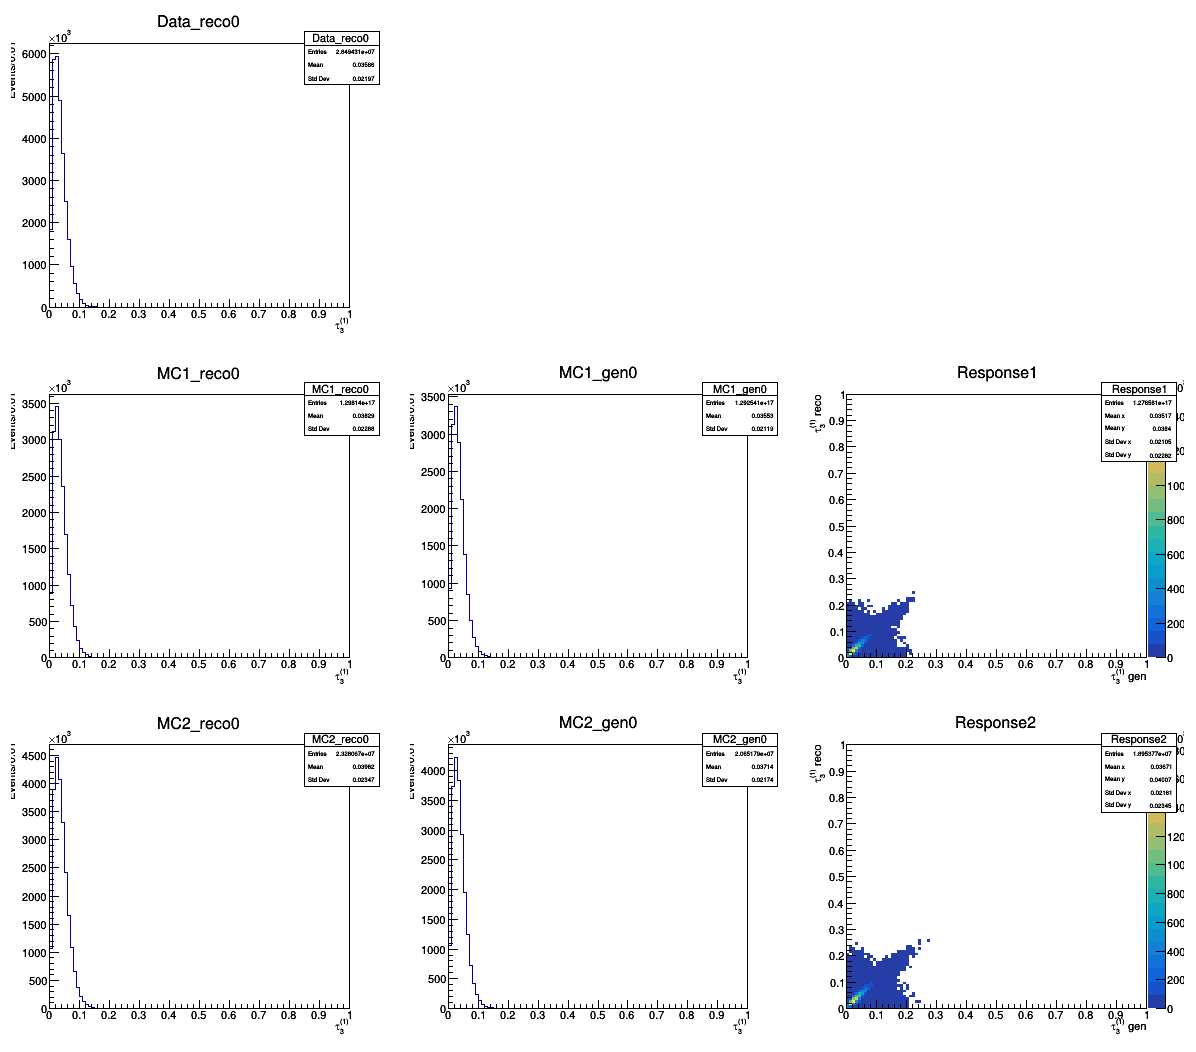

In [17]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{3}^{(1)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{3}^{(1)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{3}^{(1)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{3}^{(1)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{3}^{(1)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{3}^{(1)} gen;#tau_{3}^{(1)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{3}^{(1)} gen;#tau_{3}^{(1)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    MC2_reco0.Add(t.Get(reco),Scale[i])
    MC2_gen0.Add(t.Get(gen),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [18]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 1008582.07511 842757.468716
0.015 3537684.37045 3084331.28862
0.025 3940296.31166 3613073.28504
0.035 3525248.08314 3328266.55869
0.045 2658808.52393 2704244.419
0.055 1769783.84682 1988955.43648
0.065 1121276.5057 1365324.35616
0.075 648378.518285 887799.46842
0.085 372048.422878 536922.313377
0.095 205565.334768 305551.543968
0.105 112044.916442 169397.810469
0.115 63058.2355038 97455.3721911
0.125 34962.2420926 52313.5254856
0.135 20801.8218799 32090.7127347
0.145 8675.72993128 13941.3561657
0.155 5374.66064103 6290.27733395
0.165 2047.81512359 4331.22513613
0.175 964.025892265 1901.85665338
0.185 521.879282393 1091.24271827
0.195 188.378227035 235.862425244
0.205 260.892843171 274.408785799
0.215 76.5067008158 161.916460947
0.225 78.3667318953 15.6283143097
0.235 3.79295744844 4.09225825421
0.245 4.15474852839 3.83691446222
0.255 0.0 73.6953491235
0.265 0.0 0.0
0.275 73.5461355729 0.0
0.285 0.0 0.0
0.295 0.0 0.0
0.305 0.0 0.0
0.315 0.0 0.0
0.325 0.0 0.0
0.335 0.0 0.0
0.345 0.

In [20]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=3,start=0.,stop=0.16)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.28])))
reco_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.16)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.22,0.28])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=4,start=0.,stop=0.18)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.28])))
reco_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.18)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.23,0.28])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=6,start=0.,stop=0.2)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.28])))
reco_bins1=np.array([x for x in np.linspace(num=11,start=0.,stop=0.2)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.24,0.28])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=11,start=0.,stop=0.2)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.28])))
reco_bins1=np.array([x for x in np.linspace(num=21,start=0.,stop=0.2)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.24,0.28])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.08 0.16 0.28] 3
[0.   0.04 0.08 0.12 0.16 0.22 0.28] 6
[0.   0.06 0.12 0.18 0.28] 4
[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.23 0.28] 8
[0.   0.04 0.08 0.12 0.16 0.2  0.28] 6
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.24 0.28] 12
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.28] 11
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.24 0.28] 22


In [21]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{3}^{(1)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{3}^{(1)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{3}^{(1)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{3}^{(1)} gen;#tau_{3}^{(1)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{3}^{(1)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{3}^{(1)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{3}^{(1)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.08 0.16 0.28]
for binning 2
[0.   0.06 0.12 0.18 0.28]
for binning 3
[0.   0.04 0.08 0.12 0.16 0.2  0.28]
for binning 4
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.28]


Warning in <TROOT::Append>: Replacing existing TH1: Data_reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 6 input bins and 3 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{3}^{(1)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #4 (xaxis:#tau_{3}^{(1)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densit

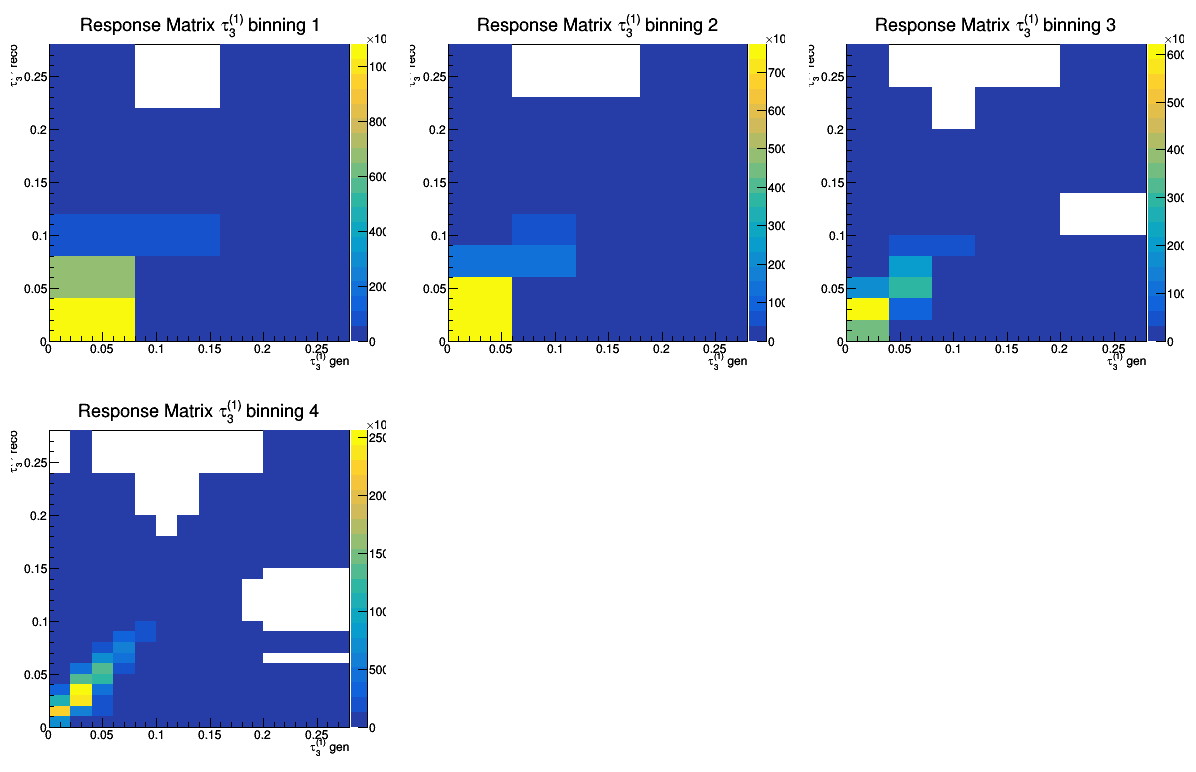

In [22]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


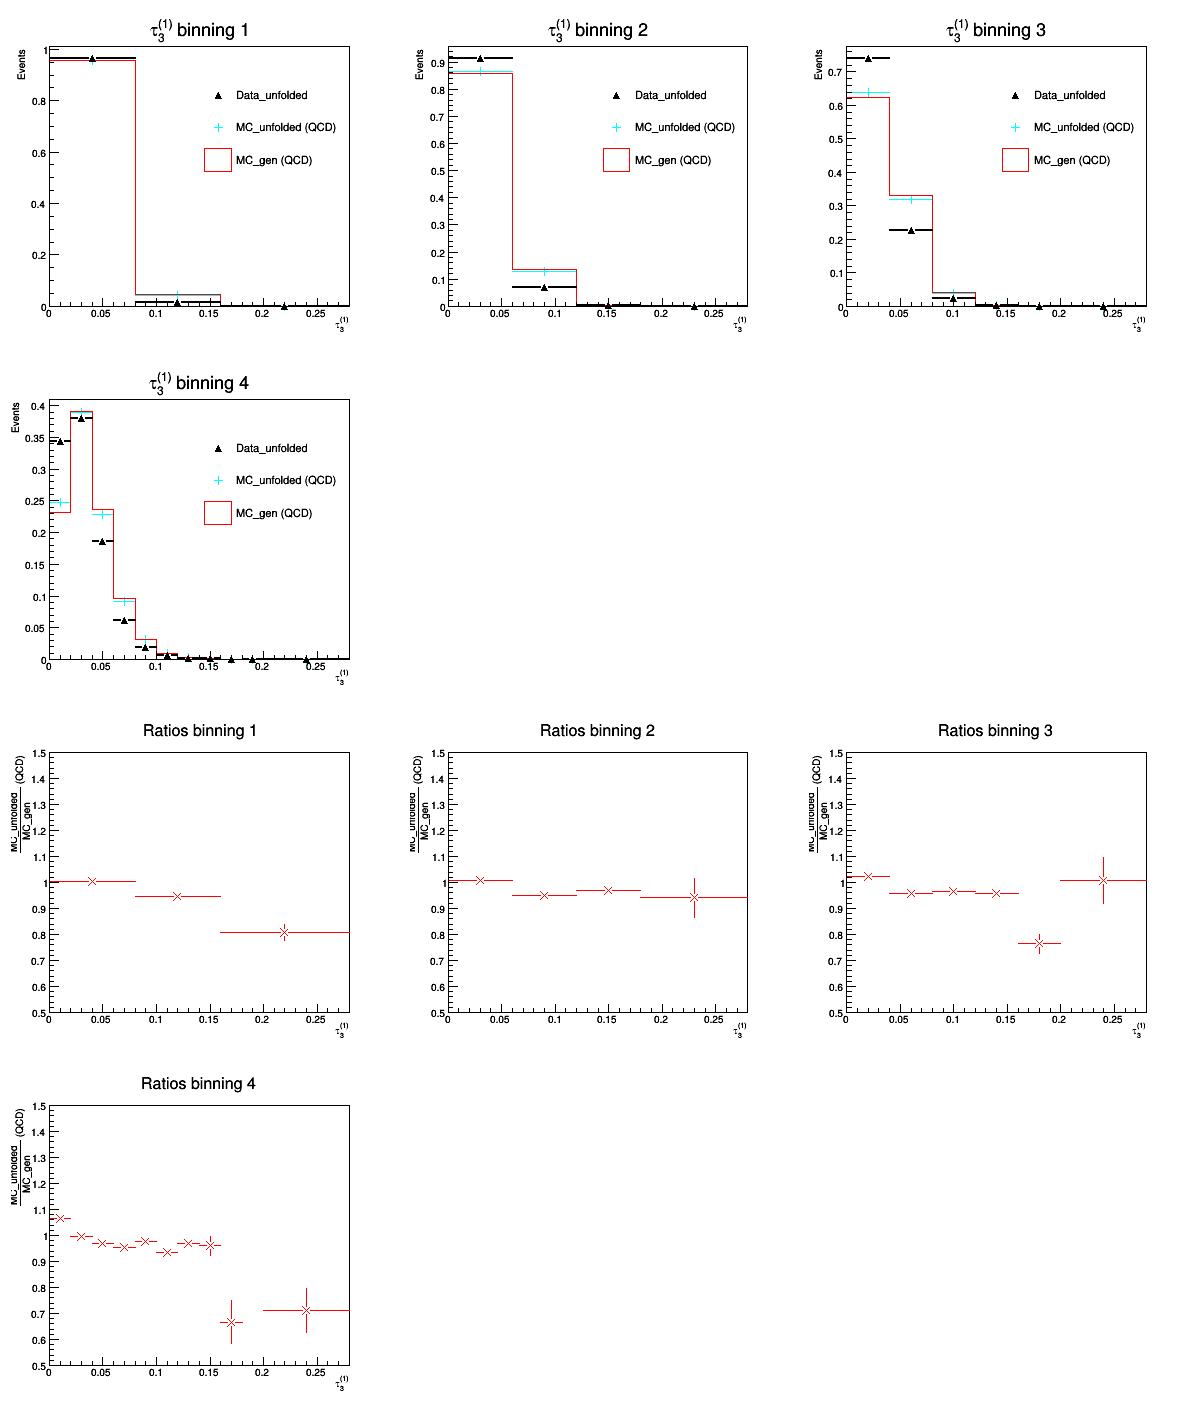

In [23]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{3}^{(1)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,len(gen_bins)+6):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

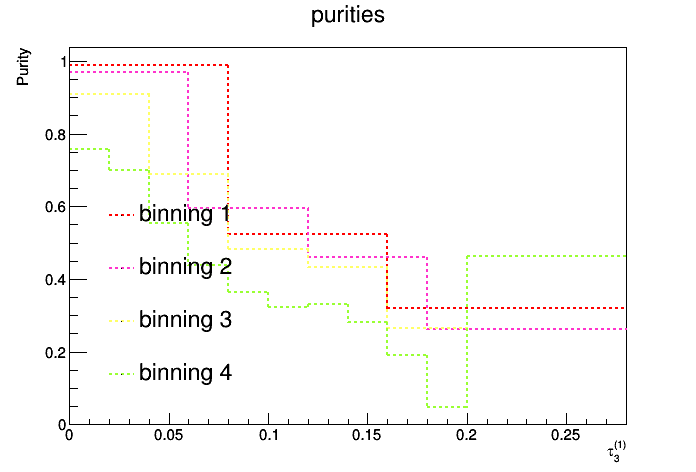

In [24]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{3}^{(1)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

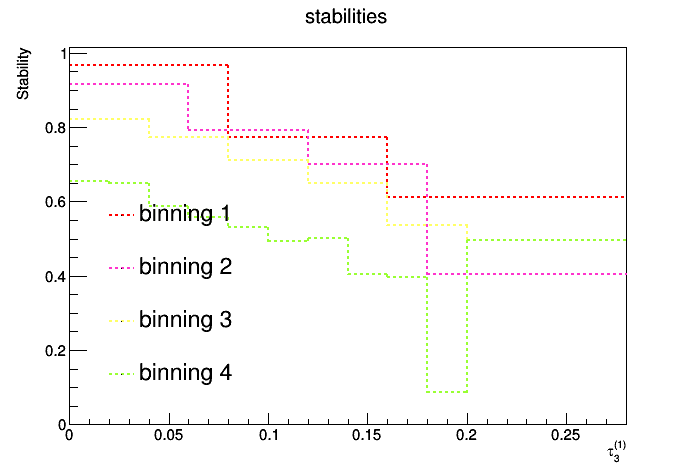

In [25]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{3}^{(1)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

# $\tau_3^{(2)}$

In [26]:
reco='recoJet_tau_2_3_WTA_kT_nom_dijetSel'
gen='genJet_tau_2_3_WTA_kT_dijetSel'
response='respJet_tau_2_3_WTA_kT_nom_dijetSel'

Warning in <TROOT::Append>: Replacing existing TH1: Data_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0


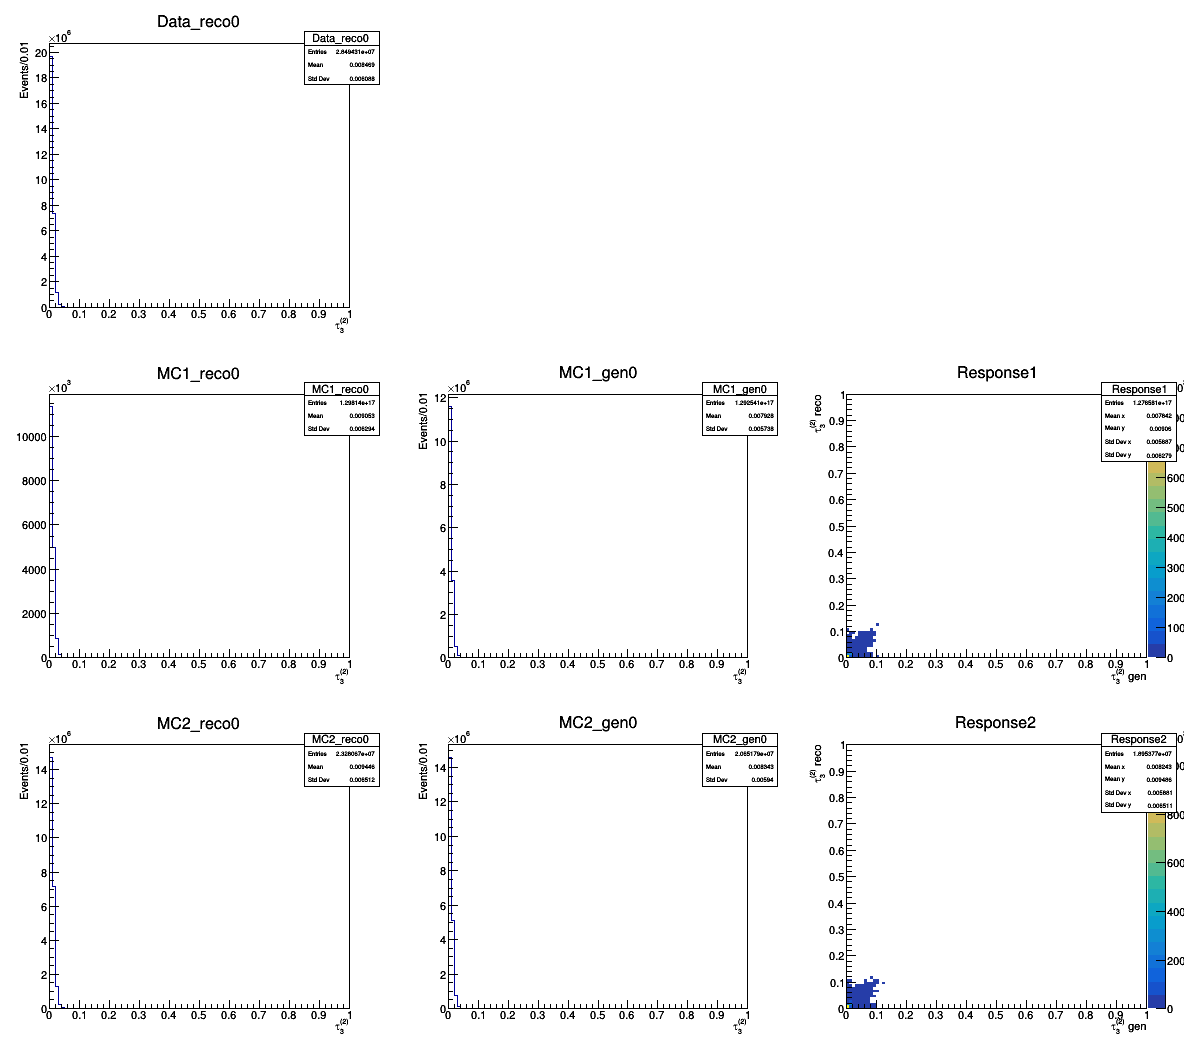

In [27]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{3}^{(2)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{3}^{(2)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{3}^{(2)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{3}^{(2)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{3}^{(2)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{3}^{(2)} gen;#tau_{3}^{(2)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{3}^{(2)} gen;#tau_{3}^{(2)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    MC2_reco0.Add(t.Get(reco),Scale[i])
    MC2_gen0.Add(t.Get(gen),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [28]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 13571055.0011 11904473.5711
0.015 4622759.36299 5837896.13864
0.025 682497.366062 1053705.30565
0.035 124971.928238 187955.854828
0.045 26631.7550668 39450.9378852
0.055 6420.65353341 9343.01169993
0.065 1561.48445636 2646.9260872
0.075 320.306797041 649.523718581
0.085 195.698388675 350.634984657
0.095 84.2285881415 92.40621592
0.105 2.79853261661 9.67411044474
0.115 0.0 0.14499142226
0.125 73.5461355729 0.0
0.135 0.0 0.0
0.145 0.0 0.0
0.155 0.0 0.0
0.165 0.0 0.0
0.175 0.0 0.0
0.185 0.0 0.0
0.195 0.0 0.0
0.205 0.0 0.0
0.215 0.0 0.0
0.225 0.0 0.0
0.235 0.0 0.0
0.245 0.0 0.0
0.255 0.0 0.0
0.265 0.0 0.0
0.275 0.0 0.0
0.285 0.0 0.0
0.295 0.0 0.0
0.305 0.0 0.0
0.315 0.0 0.0
0.325 0.0 0.0
0.335 0.0 0.0
0.345 0.0 0.0
0.355 0.0 0.0
0.365 0.0 0.0
0.375 0.0 0.0
0.385 0.0 0.0
0.395 0.0 0.0
0.405 0.0 0.0
0.415 0.0 0.0
0.425 0.0 0.0
0.435 0.0 0.0
0.445 0.0 0.0
0.455 0.0 0.0
0.465 0.0 0.0
0.475 0.0 0.0
0.485 0.0 0.0
0.495 0.0 0.0
0.505 0.0 0.0
0.515 0.0 0.0
0.525 0.0 0.0
0.535 0.0 0.0
0.545 0

In [29]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=3,start=0.,stop=0.08)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.13])))
reco_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.08)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.1,0.13])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=6,start=0.,stop=0.1)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.13])))
reco_bins1=np.array([x for x in np.linspace(num=11,start=0.,stop=0.1)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.11,0.13])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.04 0.08 0.13] 3
[0.   0.02 0.04 0.06 0.08 0.1  0.13] 6
[0.   0.02 0.04 0.06 0.08 0.1  0.13] 6
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.13] 12


In [30]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{3}^{(2)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{3}^{(2)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{3}^{(2)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{3}^{(2)} gen;#tau_{3}^{(2)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{3}^{(2)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{3}^{(2)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{3}^{(2)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.04 0.08 0.13]
for binning 2
[0.   0.02 0.04 0.06 0.08 0.1  0.13]


Warning in <TROOT::Append>: Replacing existing TH1: Data_reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 6 input bins and 3 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{3}^{(2)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #4 (xaxis:#tau_{3}^{(2)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densit

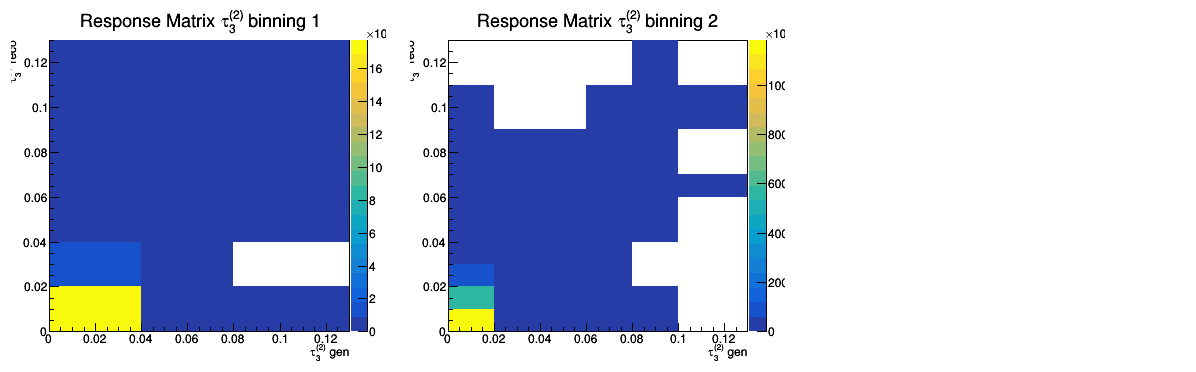

In [31]:
c=rt.TCanvas("","",0,0,1200,400)
c.Divide(3,1)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


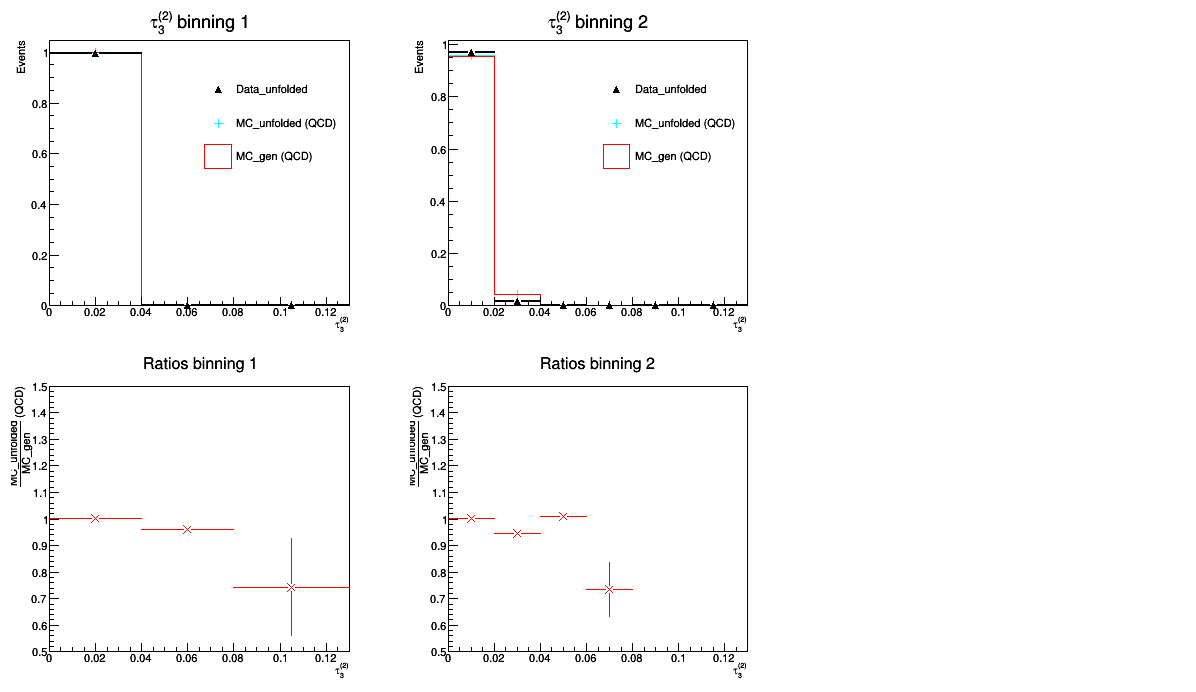

In [32]:
c=rt.TCanvas("","",0,0,1200,720)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{3}^{(2)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(3,3+len(gen_bins)):
    c.cd(i+1)
    ratio_unfoldings[i-3].Draw()
c.Draw()

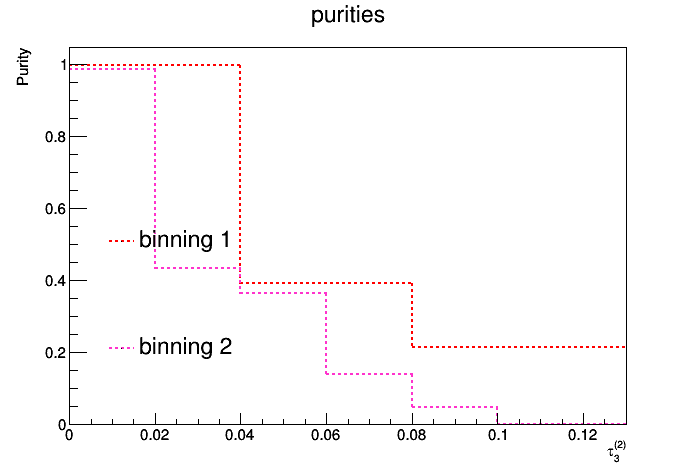

In [33]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{3}^{(2)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

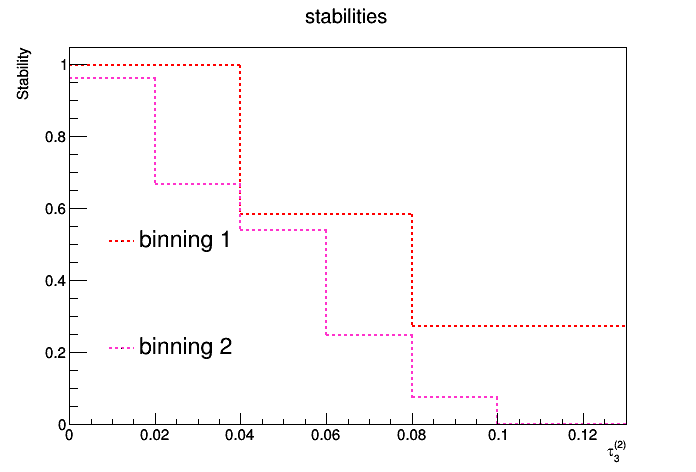

In [34]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{3}^{(2)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()